In [ ]:
import numpy as np
import pandas as pd
from sklearn.svm import SVR
from sklearn.model_selection import RepeatedKFold
import matplotlib.pyplot as plt
import sys
import os
# make paths above 'notebooks/' visible for local imports.
# +----------------------------------------------------------------------------+
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.processing import GatherFeatureDatasets
from src.utils import CrossValidation
from src.feature_selection import UnsupervisedFeatureSelection as unsup_fs
from src.feature_selection import SequentialFeatureSelection
from src import plotting

In [2]:
proc = GatherFeatureDatasets(is_p=True)

In [3]:
data_dir = '/uufs/chpc.utah.edu/common/home/koper-group3/alysha/magnitudes/feature_splits'
all_train_df = pd.read_csv(f'{data_dir}/p.train.csv')

In [4]:
stat = "YDC"
station_feature_dict, station_meta_dict, feature_names = proc.process_station_datasets(stat, 
                                                                                        all_train_df,
                                                                                        scaler=False,
                                                                                        linear_model=False,
                                                                                        source_dist_type='dist')

YDC
X shape: (2928, 45), y shape: (2928,)


In [5]:
selected_features = np.array(['amp_1', 'amp_2','signal_variance',
                    'noise_variance', 'source_depth_km',
                    'source_receiver_distance_logkm',
                    'source_receiver_back_azimuth_deg'])
features_to_add = ['amp_4', 'amp_11', 'amp_ratio_9']

In [6]:
required_inds = np.where(np.isin(feature_names, selected_features))[0]

In [7]:
inds_to_add = np.where(np.isin(feature_names, features_to_add))[0]

In [8]:
### Set Parameters ###
cv_random_state=2652124
predictor_model = SVR(kernel='rbf')
# Boolean - True if data for model needs to be scaled 
model_scaler = True
# The scoring method to use in RFECV and GridCV
scoring_method = 'r2'
# number of folds for inner CV (used for hyperparameter tuning)
cv_folds_inner = 5
# number of folds for outer CV
cv_folds_outer = 10
# number of times to repeat outer CV
n_outer_repeats = 1
# The parameter space for GridCV to search
# Decrease upper-limit of C for linear model because 100 is very slow 
svr_Cspace = [1]
svr_gspace = [0.1, 0.01, 0.001]
param_grid = [
    {'m__C': svr_Cspace, 'm__gamma': svr_gspace},
]
# True if a larger score_func value is better
larger_score_is_better = True

In [9]:
inner_grid_search, cv_inner = CrossValidation.setup_cv(predictor_model, 
                                                        param_grid, 
                                                        model_scaler=model_scaler, 
                                                        scoring_method=scoring_method, 
                                                        n_jobs=2, 
                                                        cv_folds=cv_folds_inner, 
                                                        cv_random_state=cv_random_state, 
                                                        refit_model=True)

cv_outer = RepeatedKFold(n_splits=cv_folds_outer, 
                        n_repeats=n_outer_repeats, 
                        random_state=cv_random_state)

# Require the selected features

In [10]:
X = station_feature_dict['X_train']
y = station_meta_dict['y_train']
ids, ids_scores, all_scores = SequentialFeatureSelection.do_forward_selection_cv(X,
                                                    y,
                                                    inds_to_add, 
                                                    cv_outer,
                                                    inner_grid_search,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    required_feature_ids=required_inds,
                                                    verbose=True,
                                                    n_jobs=10)

[18, 19, 40, 41, 42, 43, 44] 0.7845244286760591
[18 19 40 41 42 43 44  8] 0.7905955793276644
[18 19 40 41 42 43 44 21] 0.7931893841500319
[18 19 40 41 42 43 44 28] 0.8146806336850098
[18 19 40 41 42 43 44 28  8] 0.8139511164424181
[18 19 40 41 42 43 44 28 21] 0.8288357036371246
[18 19 40 41 42 43 44 28 21  8] 0.8295302038330437


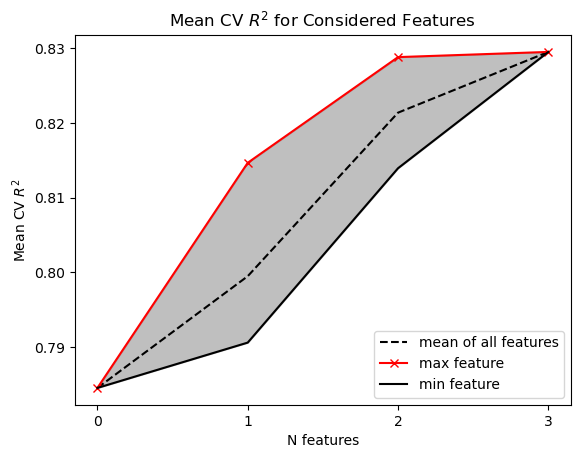

In [11]:
plotting.plot_sequential_all_feature_scores(all_scores, initial_score=ids_scores[0][0])

In [12]:
feature_names[ids]

array(['amp_1', 'amp_2', 'signal_variance', 'noise_variance',
       'source_depth_km', 'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg', 'amp_11', 'amp_4',
       'amp_ratio_9'], dtype='<U32')

# Select from all 10 features

In [16]:
np.concatenate([selected_features, features_to_add])

array(['amp_1', 'amp_2', 'signal_variance', 'noise_variance',
       'source_depth_km', 'source_receiver_distance_logkm',
       'source_receiver_back_azimuth_deg', 'amp_4', 'amp_11',
       'amp_ratio_9'], dtype='<U32')

In [19]:
all_feat_inds = np.where(np.isin(feature_names, np.concatenate([selected_features, features_to_add])))[0]

In [20]:
ids_all, ids_scores_all, all_scores_all = SequentialFeatureSelection.do_forward_selection_cv(X,
                                                    y,
                                                    all_feat_inds, 
                                                    cv_outer,
                                                    inner_grid_search,
                                                    scoring_method,
                                                    larger_score_is_better=larger_score_is_better,
                                                    verbose=True,
                                                    n_jobs=10)

8 0.3764742001521929
18 0.32130804330699
19 0.35079901939637737
21 0.45624335630215773
28 0.3854514521632353
40 0.4466458819180886
41 0.054442103744336404
42 -0.001651918672084507
43 0.04431386554991963
44 -0.012734436390331505
[21  8] 0.48341386655783414
[21 18] 0.45717722894785984
[21 19] 0.46478640875915883
[21 28] 0.495299850383171
[21 40] 0.4816289664945481
[21 41] 0.4581608975288264
[21 42] 0.46865618395826436
[21 43] 0.6468337112139076
[21 44] 0.5166892847786676
[21 43  8] 0.7259301807569166
[21 43 18] 0.654243382471176
[21 43 19] 0.6572663689639274
[21 43 28] 0.7624722690700815
[21 43 40] 0.7314053868466509
[21 43 41] 0.650931221422475
[21 43 42] 0.6844496570099114
[21 43 44] 0.6569680791946579
[21 43 28  8] 0.7680816859569266
[21 43 28 18] 0.7740971682977202
[21 43 28 19] 0.778630239777409
[21 43 28 40] 0.7853956539690943
[21 43 28 41] 0.7722638791907137
[21 43 28 42] 0.7916541908055222
[21 43 28 44] 0.7750823477528114
[21 43 28 42  8] 0.7967445483338953
[21 43 28 42 18] 0.800

In [27]:
plotting.set_default_fontsizes()

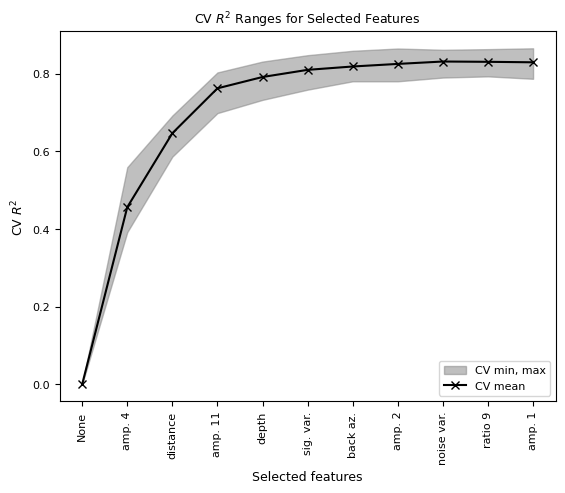

In [28]:
feat_plot_names = proc.get_feature_plot_names(source_dist_type='dist')[ids_all]
plotting.plot_sequential_selected_feature_scores(ids_scores_all, feat_plot_names)

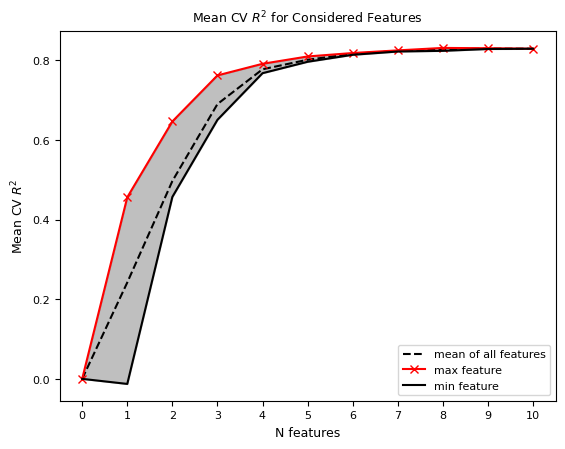

In [45]:
plotting.plot_sequential_all_feature_scores(all_scores_all)

Put updated plotting function here so I don't have to rerun the feature selection

In [39]:
SMALL_SIZE=8
MEDIUM_SIZE=9
LARGE_SIZE=9
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)  # fontsize of the figure title
plt.rc('figure', labelsize=MEDIUM_SIZE)

In [42]:
def plot_sequential_selected_feature_scores(ids_scores, 
                                            feature_names, 
                                            base_set_name="None",
                                            title="CV $R^2$ Ranges for Selected Features",
                                            savefigname=None):
    feat_plot_names = np.concatenate([[base_set_name], feature_names])
    x = np.arange(ids_scores.shape[0])
    fig, ax = plt.subplots(1, constrained_layout=True, figsize=(4, 3))
    ax.fill_between(x, ids_scores[:, 1], ids_scores[:, 2], color='gray', 
                     alpha=0.5, label='CV range')
    ax.plot(x, ids_scores[:, 0], color='k', marker='x', label='CV mean')
    ax.set_xticks(x, feat_plot_names, rotation=90)
    ax.set_xlabel("Added Feature")
    ax.set_ylabel("CV $R^2$")
    ax.legend(loc='lower right')
    ax.set_title(title)
    ax.grid(axis='y')
    if savefigname is not None:
        fig.savefig(savefigname, dpi=300)
    print(fig.get_size_inches())

[4. 3.]


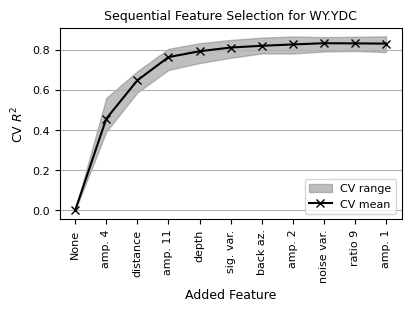

In [ ]:
plot_sequential_selected_feature_scores(ids_scores_all, 
                                        feat_plot_names,
                                        title='Sequential Feature Selection for WY.YDC',
                                        savefigname='../../../figures/sequentialYDC.png')